In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import pickle

%matplotlib inline

In [2]:
import sys
sys.path.append("../code/")

In [3]:
from tensor_custom_core import *

In [4]:
tensor = pickle.load(open('12H-input.pkl','r'))

In [7]:
freq = '12H'
error_rank = {}
for r in range(1, 2):
    print("*"*20)
    
    pred = pickle.load(open("{}-{}-pred-hourly.pkl".format(freq, r),'r'))
    diff = pred-tensor
    home = 0
    appliance = 0
    error = {}
    from common import APPLIANCES_ORDER
    for appliance, appliance_name in enumerate(APPLIANCES_ORDER):
        print(appliance_name, r)
        error[appliance_name] = {}
        for home in range(tensor.shape[0]):
            error[appliance_name][home] = 0.
            for hour in range(2):
                y_pred = pred[home, appliance, :, hour]
                y_true = tensor[home, appliance, :, hour]
                mask = ~np.isnan(y_true)
                if np.nansum(y_true)>1:
                    error_hour =  np.nansum((y_pred - y_true)[mask])/np.nansum(y_true)

                    #error_hour =  np.nansum((y_pred - y_true)[mask])/max(np.nansum(y_true), np.nansum(y_pred))
                    error[appliance_name][home] += error_hour**2
            error[appliance_name][home] = np.sqrt(error[appliance_name][home])
    error = pd.DataFrame(error)
    error = error.replace(0.0, np.nan)
    error_rank[r] = error

********************
('aggregate', 1)
('hvac', 1)
('fridge', 1)
('mw', 1)
('dw', 1)
('wm', 1)
('oven', 1)


In [21]:
pd.DataFrame(error_rank[1]).median().round(2)

aggregate    0.16
dw           0.79
fridge       0.48
hvac         0.43
mw           0.75
oven         0.80
wm           1.31
dtype: float64

In [14]:
error = error_rank[pd.Panel(error_rank).median().sum().argmin()]

In [15]:
def plot_home_appliance(home, appliance, ax, kind="worst",):
    appliance_num = APPLIANCES_ORDER.index(appliance)
    pd.DataFrame(tensor[home, appliance_num,:,:]).T.plot(legend=False, color='k',alpha=0.2, ax=ax)
    pd.DataFrame(pred[home, appliance_num,:,:]).T.plot(legend=False, color='g',alpha=0.1, ax=ax)
    import matplotlib.patches as mpatches

    black_patch = mpatches.Patch(color='black', label='GT')
    green_patch = mpatches.Patch(color='green', label='Predicted')

    ax.legend(handles=[black_patch, green_patch])
    ax.set_xlabel("Hour of day")
    if kind=="worst":
        ax.set_ylabel(appliance)
    ax.set_title("Home # {}".format(home))
    return ax

In [16]:
import sys

In [17]:
error_rank[3].median().round(2)

KeyError: 3

aggregate
hvac
fridge
mw
dw
wm
oven


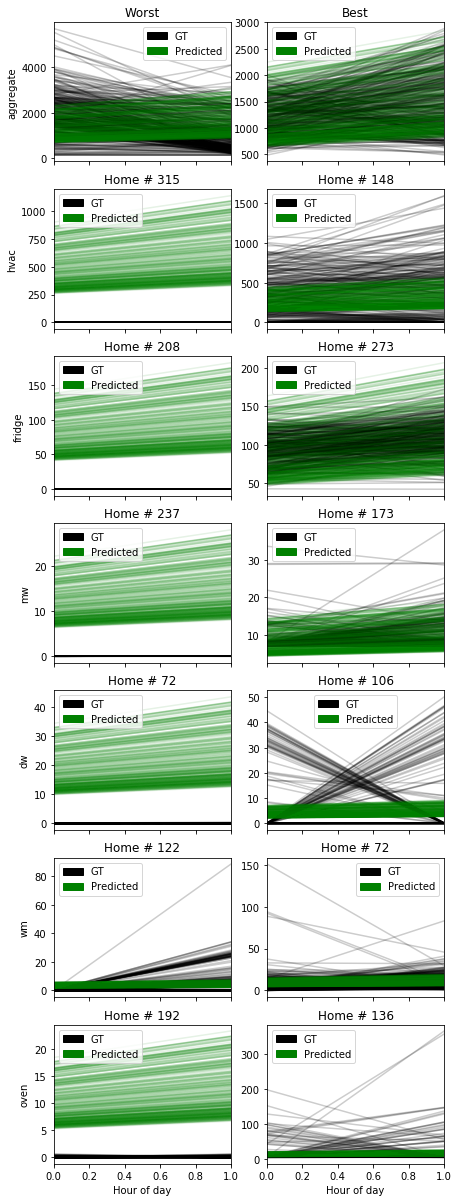

In [18]:

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(7, 21), sharex=True)
for appliance_num, appliance in enumerate(APPLIANCES_ORDER):
    print(appliance)
    sys.stdout.flush()
    worst = error[appliance].argmax()
    plot_home_appliance(worst, appliance, ax[appliance_num, 0], "worst")
    best = error[appliance].argmin()
    plot_home_appliance(best, appliance, ax[appliance_num, 1], "best")
ax[0, 0].set_title("Worst")
ax[0, 1].set_title("Best")



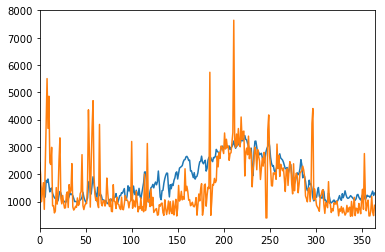

In [87]:
pd.Series(y_pred).plot()
pd.Series(y_true).plot()

In [68]:
mask = ~np.isnan(tensor[home, appliance, :, :])
pred[home, appliance, :, :][mask].shape

(8756,)

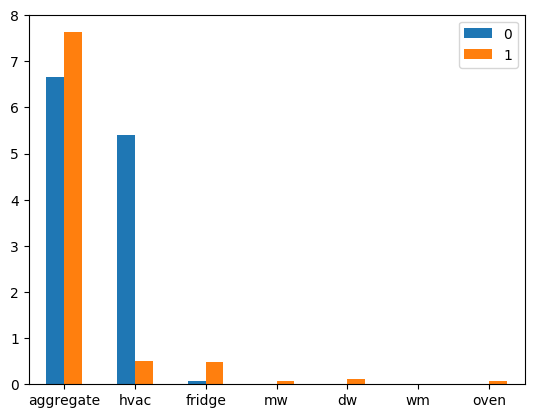

In [29]:
sns.reset_defaults()
from common import APPLIANCES_ORDER
pd.DataFrame(appliance, index=APPLIANCES_ORDER).plot(kind='bar',rot=0)

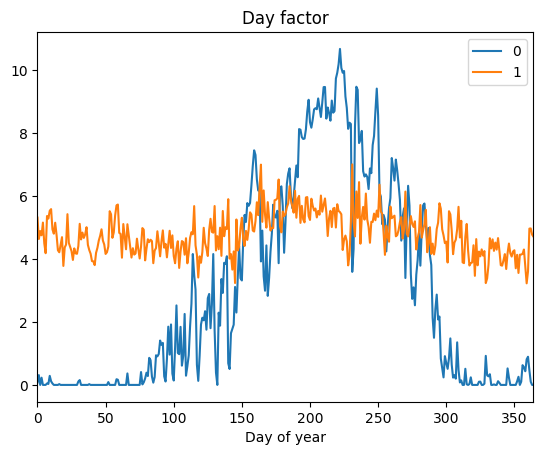

In [30]:
pd.DataFrame(day).plot()
plt.xlabel("Day of year")
plt.title("Day factor")

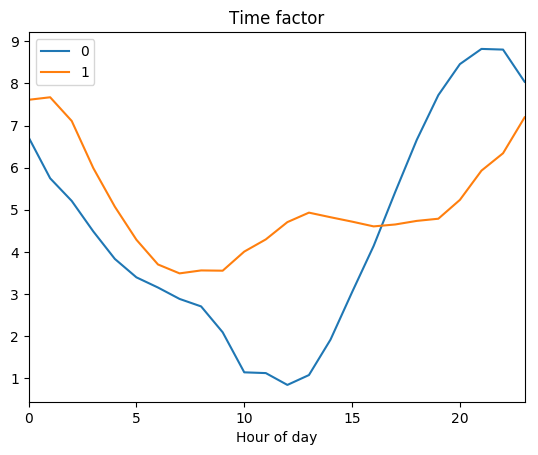

In [31]:
pd.DataFrame(hour).plot()
plt.xlabel("Hour of day")
plt.title("Time factor")

In [10]:
import seaborn as sns

In [59]:
tensor[:, 0, :, :].shape


(318, 365, 24)

In [22]:
labels[0].get_text()

u'364'

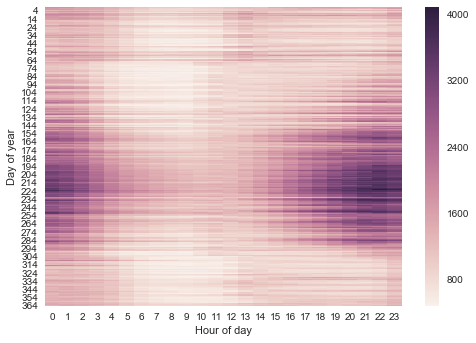

In [24]:
ax = sns.heatmap(np.nanmean(tensor[:, 0, :, :], axis=0))
labels = ax.get_yticklabels()
o = []
for i, x in enumerate(labels):
    if i%10==0:
        o.append(x.get_text())
    else:
        o.append(' ')

ax.set_yticklabels(o);
plt.xlabel("Hour of day")
plt.ylabel("Day of year")

In [56]:
%matplotlib inline

In [48]:
t = tensor[:20, :, :, :]
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
pred = np.zeros_like(t)
pred[:] = np.nan

for train, test in kf.split(t):
    print "*"*20, train, test
    t_copy = t.copy()
    t_copy[test][1:, :, :] = np.nan
    home, appliance, day, hour = stf_4dim(tensor=t_copy, r=2, num_iter=200, lr=2)
    pred[test] = np.einsum("Hr, Ar, Dr, Tr ->HADT", home, appliance, day, hour)[test]
   
    
    

******************** [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3]
920.948306858 0
418.718995597 200
418.713382716 400
418.708294084 600
418.705847477 800
******************** [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [4 5 6 7]
920.948306858 0


KeyboardInterrupt: 

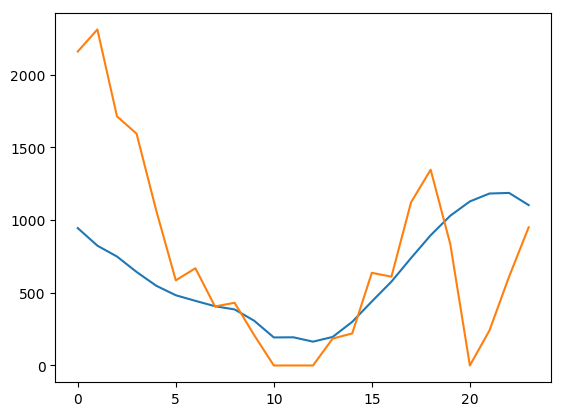

In [47]:
plt.plot(pred[0, 1, 190, :])
plt.plot(t[0, 1, 190, :])